<a href="https://colab.research.google.com/github/garfield-gray/DataMining/blob/main/Deep_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import torch
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import json

In [2]:
import os
import numpy as np
import pandas as pd
import networkx as nx
from scipy import sparse
from sklearn.metrics import f1_score
from sklearn.decomposition import NMF, TruncatedSVD
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, ElasticNet

# Imperical

## 1

In [3]:
# Address of files
%cd /content/drive/MyDrive/Uni/Data/DataMining/Winter2024/CA#6
!ls

/content/drive/MyDrive/Uni/Data/DataMining/Winter2024/CA#6
CA6.pdf		 citing.txt	      Kaggle		   musae_git_features.json  README.txt
CA#6Report.gdoc  Deep_Learning.ipynb  musae_git_edges.csv  musae_git_target.csv


In [4]:

json_file_path = 'musae_git_features.json'
with open(json_file_path) as f:
    data = json.load(f)

df1 = pd.DataFrame.from_dict(data, orient='index')

df1['node'] = df1.index
df1['node'] = df1['node'].astype(int)

melted_df = df1.melt(id_vars=['node'], var_name='feature_name', value_name='feature')


result_df = melted_df.drop(columns=['feature_name'])

features = result_df.sort_values(by=['node']).dropna()
features['feature'] = features['feature'].astype(int)

In [5]:
target = pd.read_csv("musae_git_target.csv")

edges = pd.read_csv("musae_git_edges.csv")

In [6]:
features

,node,feature
0,0,1574
678600,0,1578
640900,0,2115
603200,0,3098
565500,0,2480
...,...,...
188499,37699,676
150799,37699,3437
113099,37699,1663
75399,37699,509


In [7]:
edges

,id_1,id_2
0,0,23977
1,1,34526
2,1,2370
3,1,14683
4,1,29982
...,...,...
288998,37527,37596
288999,37529,37601
289000,37644,2347
289001,25879,2347


In [8]:
target

,id,name,ml_target
0,0,Eiryyy,0
1,1,shawflying,0
2,2,JpMCarrilho,1
3,3,SuhwanCha,0
4,4,sunilangadi2,1
...,...,...,...
37695,37695,shawnwanderson,1
37696,37696,kris-ipeh,0
37697,37697,qpautrat,0
37698,37698,Injabie3,1


## 2

In [9]:
edges.where(edges['id_1'] == 1).dropna().sort_values(by=['id_2'])

,id_1,id_2
2,1.0,2370.0
3,1.0,14683.0
6,1.0,20363.0
5,1.0,21142.0
7,1.0,23830.0
4,1.0,29982.0
8,1.0,34035.0
1,1.0,34526.0


In [10]:
edges.where(edges['id_1'] == 2370).dropna().sort_values(by=['id_2'])

,id_1,id_2
38036,2370.0,184.0
38041,2370.0,2979.0
38047,2370.0,3226.0
38066,2370.0,5348.0
38059,2370.0,6847.0
38050,2370.0,9465.0
38051,2370.0,10787.0
38040,2370.0,11279.0
38055,2370.0,12859.0
38042,2370.0,13887.0


In [11]:
features['feature'].unique().shape

(4005,)

In [12]:
target['ml_target'].value_counts()

ml_target
0    27961
1     9739
Name: count, dtype: int64

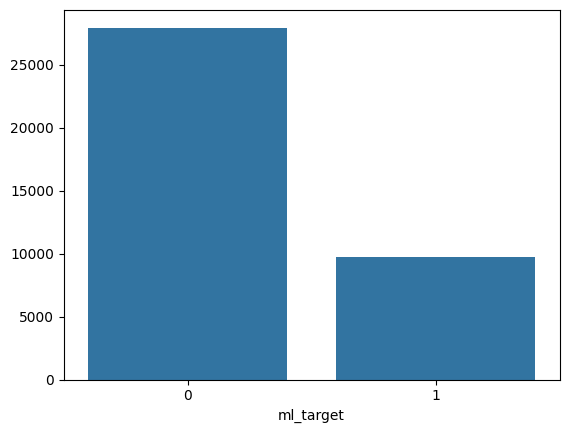

In [13]:

sns.barplot(x=target['ml_target'].value_counts().index, y=target['ml_target'].value_counts().values)
plt.show()


In [ ]:
features

,node,feature
0,0,1574
678600,0,1578
640900,0,2115
603200,0,3098
565500,0,2480
...,...,...
188499,37699,676
150799,37699,3437
113099,37699,1663
75399,37699,509


# 3

In [ ]:
def transform_features_to_sparse(table):
    table["weight"] = 1
    table = table.values.tolist()
    index_1 = [row[0] for row in table]
    index_2 =  [row[1] for row in table]
    values =  [row[2] for row in table]
    count_1, count_2 = max(index_1)+1, max(index_2)+1
    sp_m = sparse.csr_matrix(sparse.coo_matrix((values,(index_1,index_2)),shape=(count_1,count_2),dtype=np.float32))
    return sp_m

In [ ]:
def normalize_adjacency(raw_edges):
    raw_edges_t = pd.DataFrame()
    raw_edges_t["id_1"] = raw_edges["id_2"]
    raw_edges_t["id_2"] = raw_edges["id_1"]
    raw_edges = pd.concat([raw_edges,raw_edges_t])
    edges = raw_edges.values.tolist()
    graph = nx.from_edgelist(edges)
    ind = range(len(graph.nodes()))
    degs = [1.0 for node in graph.nodes()]
    A = transform_features_to_sparse(raw_edges)
    degs = sparse.csr_matrix(sparse.coo_matrix((degs, (ind, ind)), shape=A.shape,dtype=np.float32))
    A = A.dot(degs)
    return A

In [ ]:
y = np.array(target["ml_target"])
A = normalize_adjacency(edges)
X = transform_features_to_sparse(features)
X_tilde = A.dot(X)

In [ ]:
import torch
A = torch.tensor(A.toarray())
X = torch.tensor(X.toarray())

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class GCNLayer(nn.Module):
    """
        GCN layer

        Args:
            input_dim (int): Dimension of the input
            output_dim (int): Dimension of the output (a softmax distribution)
            A (torch.Tensor): 2D adjacency matrix
    """

    def __init__(self, input_dim: int, output_dim: int, A: torch.Tensor):
        super(GCNLayer, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.A = A

        # A_hat = A + I
        self.A_hat = self.A + torch.eye(self.A.size(0), device=self.A.device)

        # Create diagonal degree matrix D
        D = torch.sum(self.A_hat, dim=1)

        # Create D^{-1/2}
        D_neg_sqrt = torch.pow(D, -0.5)

        # Create a new tensor with the diagonal elements and zeros elsewhere
        self.D_neg_sqrt = torch.diag(D_neg_sqrt)

        # Initialise the weight matrix as a parameter
        self.W = nn.Parameter(torch.rand(input_dim, output_dim))

    def forward(self, X: torch.Tensor):
        # D^-1/2 * A_hat * D^-1/2
        DA = torch.matmul(self.D_neg_sqrt, self.A_hat)
        support_1 = torch.matmul(DA, self.D_neg_sqrt)

        # (D^-1/2 * A_hat * D^-1/2) * (X * W)
        support_2 = torch.matmul(support_1, X)
        support_2 = torch.matmul(support_2, self.W)

        # ReLU(D^-1/2 * A_hat * D^-1/2 * X * W)
        H = F.relu(support_2)

        return H


input_dim = 37700
output_dim = 2


gcn_layer = GCNLayer(input_dim, output_dim, A)


output = gcn_layer(X)

print(output)


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class GCNLayer(nn.Module):
    """
        GCN layer

        Args:
            input_dim (int): Dimension of the input
            output_dim (int): Dimension of the output (a softmax distribution)
            A (torch.Tensor): 2D adjacency matrix
    """

    def __init__(self, input_dim: int, output_dim: int, A: torch.Tensor):
        super(GCNLayer, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.A = A

        # A_hat = A + I
        self.A_hat = self.A + torch.eye(self.A.size(0))

        # Create diagonal degree matrix D
        self.ones = torch.ones(input_dim, input_dim)
        self.D = torch.matmul(self.A.float(), self.ones.float())

        # Extract the diagonal elements
        self.D = torch.diag(self.D)

        # Create a new tensor with the diagonal elements and zeros elsewhere
        self.D = torch.diag_embed(self.D)

        # Create D^{-1/2}
        self.D_neg_sqrt = torch.diag_embed(torch.diag(torch.pow(self.D, -0.5)))

        # Initialise the weight matrix as a parameter
        self.W = nn.Parameter(torch.rand(input_dim, output_dim))

    def forward(self, X: torch.Tensor):

        # D^-1/2 * (A_hat * D^-1/2)
        support_1 = torch.matmul(self.D_neg_sqrt, torch.matmul(self.A_hat, self.D_neg_sqrt))

        # (D^-1/2 * A_hat * D^-1/2) * (X * W)
        support_2 = torch.matmul(support_1, torch.matmul(X, self.W))

        # ReLU(D^-1/2 * A_hat * D^-1/2 * X * W)
        H = F.relu(support_2)

        return H


# Example Usage
input_dim = 37700  # Assuming the input dimension is 3
output_dim = 2  # Assuming the output dimension is 2
# Example adjacency matrix
# A = torch.tensor([[1., 0., 0.],
#                   [0., 1., 1.],
#                   [0., 1., 1.]])
# Create the GCN Layer
gcn_layer = GCNLayer(input_dim, output_dim, A)
# Example input feature matrix
# X = torch.tensor([[1., 2., 3.],
#                   [4., 5., 6.],
#                   [7., 8., 9.]])
# Forward pass
output = gcn_layer(X)

(output)
# tensor([[ 6.3438,  5.8004],
#         [13.3558, 13.7459],
#         [15.5052, 16.0948]], grad_fn=<ReluBackward0>)

# 3(kinad works)

In [ ]:
import numpy as np
import pandas as pd
import networkx as nx
import scipy.sparse as sp
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv

# Function to transform features into sparse matrix
def transform_features_to_sparse(table):
    table["weight"] = 1
    table = table.values.tolist()
    index_1 = [row[0] for row in table]
    index_2 = [row[1] for row in table]
    values = [row[2] for row in table]
    count_1, count_2 = max(index_1)+1, max(index_2)+1
    sp_m = sp.csr_matrix(sp.coo_matrix((values, (index_1, index_2)), shape=(count_1, count_2), dtype=np.float32))
    return sp_m

# Function to normalize adjacency matrix
def normalize_adjacency(raw_edges):
    raw_edges_t = pd.DataFrame()
    raw_edges_t["id_1"] = raw_edges["id_2"]
    raw_edges_t["id_2"] = raw_edges["id_1"]
    raw_edges = pd.concat([raw_edges, raw_edges_t])
    edges = raw_edges.values.tolist()
    graph = nx.from_edgelist(edges)
    ind = range(len(graph.nodes()))
    degs = [1.0 / graph.degree(node) for node in graph.nodes()]
    A = transform_features_to_sparse(raw_edges)
    degs = sp.csr_matrix(sp.coo_matrix((degs, (ind, ind)), shape=A.shape, dtype=np.float32))
    A = A.dot(degs)
    return A

features = features   # Replace ... with your features DataFrame
edges =   edges # Replace ... with your edges DataFrame
target =  target # Replace ... with your target DataFrame

# Convert data to appropriate formats
A = normalize_adjacency(edges)
X = transform_features_to_sparse(features)

# Convert data into PyTorch tensors
X = torch.FloatTensor(X.toarray())  # Convert sparse matrix to dense tensor
y = torch.LongTensor(target["ml_target"].values)  # Assuming ml_target is categorical (class labels)

# Create a NetworkX graph and extract node features and edge indices
edges = edges[['id_1', 'id_2']].values.tolist()
graph = nx.Graph(edges)
num_nodes = len(graph.nodes())

# Generate node features (random for illustration purposes, replace with actual features)
node_features = torch.randn(num_nodes, X.shape[1])  # Replace with your actual node features

# Generate edge indices in COO format for PyTorch Geometric
edge_index = np.array(list(graph.edges())).T
edge_index = torch.LongTensor(edge_index)

# Prepare data for PyTorch Geometric
data = Data(x=node_features, edge_index=edge_index, y=y)


In [ ]:
class GCN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, output_dim)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        # First graph convolution layer
        x = self.conv1(x, edge_index)
        x = F.relu(x)

        # Second graph convolution layer
        x = self.conv2(x, edge_index)

        # Global pooling over all nodes (example using global mean pooling)
        x = global_mean_pool(x, data.batch)  # Use global mean pooling or global max pooling

        return x

# Helper function for global pooling (example using global mean pooling)
def global_mean_pool(x, batch):
    batch_size = batch.max().item() + 1
    return torch.stack([x[batch == i].mean(dim=0) for i in range(batch_size)])


In [ ]:
def train(model, optimizer, criterion, data):
    model.train()
    optimizer.zero_grad()
    output = model(data)
    loss = criterion(output, data.y)
    loss.backward()
    optimizer.step()
    return loss.item()

def evaluate(model, data):
    model.eval()
    with torch.no_grad():
        output = model(data)
        pred = output.argmax(dim=1)
        accuracy = (pred == data.y).sum().item() / len(data.y)
    return accuracy

# Initialize model, optimizer, loss function
model = GCN(input_dim=X.shape[1], hidden_dim=64, output_dim=2)  # Adjust output_dim based on your number of classes
optimizer = optim.Adam(model.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()

# Train the model
for epoch in range(50):  # Adjust number of epochs as needed
    loss = train(model, optimizer, criterion, data)
    print(f"Epoch {epoch+1}, Loss: {loss:.4f}")

# Evaluate the model
accuracy = evaluate(model, data)
print(f"Test Accuracy: {accuracy:.4f}")


AttributeError: 'NoneType' object has no attribute 'max'

# Works!

In [ ]:
import os
import numpy as np
import pandas as pd
import networkx as nx
from scipy import sparse
from sklearn.metrics import f1_score
from sklearn.decomposition import NMF, TruncatedSVD
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, ElasticNet

In [ ]:
def transform_features_to_sparse(table):
    table["weight"] = 1
    table = table.values.tolist()
    index_1 = [row[0] for row in table]
    index_2 =  [row[1] for row in table]
    values =  [row[2] for row in table]
    count_1, count_2 = max(index_1)+1, max(index_2)+1
    sp_m = sparse.csr_matrix(sparse.coo_matrix((values,(index_1,index_2)),shape=(count_1,count_2),dtype=np.float32))
    return sp_m

In [ ]:
def normalize_adjacency(raw_edges):
    raw_edges_t = pd.DataFrame()
    raw_edges_t["id_1"] = raw_edges["id_2"]
    raw_edges_t["id_2"] = raw_edges["id_1"]
    raw_edges = pd.concat([raw_edges,raw_edges_t])
    edges = raw_edges.values.tolist()
    graph = nx.from_edgelist(edges)
    ind = range(len(graph.nodes()))
    degs = [1.0/graph.degree(node) for node in graph.nodes()]
    A = transform_features_to_sparse(raw_edges)
    degs = sparse.csr_matrix(sparse.coo_matrix((degs, (ind, ind)), shape=A.shape,dtype=np.float32))
    A = A.dot(degs)
    return A

In [ ]:
y = np.array(target["ml_target"])
A = normalize_adjacency(edges)
X = transform_features_to_sparse(features)
X_tilde = A.dot(X)

In [ ]:
def eval_factorization(W,y):
    scores = []
    for i in range(10):
        X_train, X_test, y_train, y_test = train_test_split(W, y, test_size=0.9, random_state = i)
        model = LogisticRegression(C=0.01, solver = "saga",multi_class = "auto")
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        score = f1_score(y_test, y_pred, average = "weighted")
        scores.append(score)
    print(np.mean(scores))

In [ ]:
model = TruncatedSVD(n_components=16, random_state=0)
W = model.fit_transform(X)
model = TruncatedSVD(n_components=16, random_state=0)
W_tilde = model.fit_transform(A)

In [ ]:
eval_factorization(W, y)
eval_factorization(np.concatenate([W,W_tilde],axis=1), y)

0.8142445666083331


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


0.8170890312300629
